In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
import BiQ_Common_Fxns as BiQ


Coefficients:
[-5.07297078e-07  2.00053204e+00  5.91838781e+00]

Summary Statistics:
+--------------------+------------+------------+------------+
| Parameter          |   Estimate | CI Lower   | CI Upper   |
+====================+============+============+============+
| R-squared          |   0.999999 |            |            |
+--------------------+------------+------------+------------+
| Adjusted R-squared |   0.999999 |            |            |
+--------------------+------------+------------+------------+


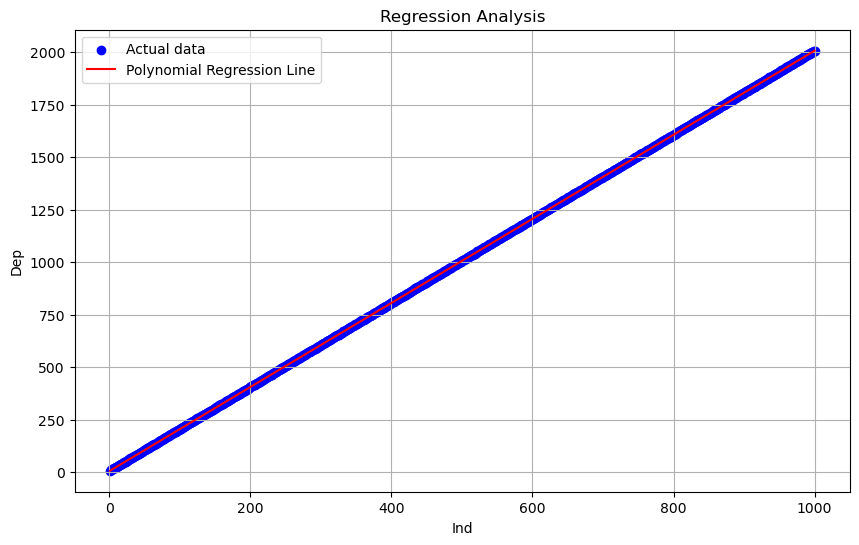

In [43]:
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)  # Read Excel file into a temporary DataFrame
        df = df.dropna(axis=1, how='all')  # Drop columns that are entirely blank
        return df  # Return the DataFrame
    except Exception as e:
        print(f"Error reading Excel file: {e}")  # Print error message if file reading fails
        return None  # Return None if an error occurs

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    # Get column names from the DataFrame
    columns = df.columns.tolist()

    while True:
        col_name = simpledialog.askstring(title, f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}")
        if col_name is None:
            return None  # User canceled the input
        elif col_name in columns:
            return col_name
        else:
            print(f"Column '{col_name}' not found in the DataFrame.")

def fit_linear_regression(df, x_col, y_col):
    """Fit a linear regression model."""
    formula = f"{y_col} ~ {x_col}"
    model = ols(formula, data=df).fit()
    coefficients = model.params  # Get the coefficients
    return model, coefficients  # Return both the model and coefficients

def fit_polynomial_regression(df, x_col, y_col, degree):
    """Fit a polynomial regression model."""
    # Use np.polyfit to fit a polynomial of specified degree
    coeffs = np.polyfit(df[x_col], df[y_col], degree)
    model = np.poly1d(coeffs)
    return model, coeffs  # Return both the model and coefficients

def calculate_summary_stats(df, x_col, y_col, model, regression_type):
    """Calculate summary statistics for the regression model."""
    summary_data = []

    if regression_type == 1:  # Linear regression
        r_squared = model.rsquared
        adj_r_squared = model.rsquared_adj
    elif regression_type == 2:  # Polynomial regression
        # Calculate predicted values
        predicted_values = model(df[x_col])

        # Calculate R-squared and adjusted R-squared manually
        y_mean = np.mean(df[y_col])
        ss_total = np.sum((df[y_col] - y_mean) ** 2)
        ss_reg = np.sum((predicted_values - y_mean) ** 2)
        r_squared = ss_reg / ss_total
        adj_r_squared = 1 - (1 - r_squared) * (df.shape[0] - 1) / (df.shape[0] - df.shape[1] - 1)
    else:
        print("Error: Invalid regression type.")
        return

    summary_data.append(['R-squared', r_squared, None, None])
    summary_data.append(['Adjusted R-squared', adj_r_squared, None, None])

    return summary_data

def plot_regression_line(df, x_col, y_col, model, degree=None):
    """Plot the regression line."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], color='blue', label='Actual data')

    if degree:
        x_vals = np.linspace(df[x_col].min(), df[x_col].max(), 100)
        y_vals = model(x_vals)  # Use the model directly for polynomial regression
        plt.plot(x_vals, y_vals, color='red', label='Polynomial Regression Line')
    else:
        plt.plot(df[x_col], model.predict(), color='red', label='Linear Regression Line')

    plt.title('Regression Analysis')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.show()


def main():
    # Open a file dialog to select Excel file
    root = Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    # Read Excel file into DataFrame
    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    # Get user input for selecting independent variable (X)
    x_col = get_user_column_selection(df, "Independent Variable (X)")
    if x_col is None:
        print("Error: Invalid input for independent variable.")
        return

    # Get user input for selecting dependent variable (Y)
    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    # Perform regression analysis
    regression_type = simpledialog.askinteger("Input", "Enter 1 for Linear Regression or 2 for Polynomial Regression:")
    if regression_type == 1:
        model, coefficients = fit_linear_regression(df, x_col, y_col)
        print("\nCoefficients:")
        print(coefficients)
    elif regression_type == 2:
        degree = simpledialog.askinteger("Input", "Enter polynomial degree:")
        model, coefficients = fit_polynomial_regression(df, x_col, y_col, degree)
        print("\nCoefficients:")
        print(coefficients)
    else:
        print("Error: Invalid regression type.")
        return

    # Calculate summary statistics
    summary_data = calculate_summary_stats(df, x_col, y_col, model, regression_type)

    # Print Summary Statistics Table
    print("\nSummary Statistics:")
    print(tabulate(summary_data, headers=["Parameter", "Estimate", "CI Lower", "CI Upper"], tablefmt="grid"))

    # Plot Regression Line
    plot_regression_line(df, x_col, y_col, model, degree=degree if regression_type == 2 else None)

if __name__ == "__main__":
    main()